Natural Frequency symbolic function
----

Funções utilizadas para cálculos simbolicos e substituição de valores
do problema para encontrar as frequências naturais do sistema
de um manipulador robótico de n-links

Cálculo baseado no artigo
PIETRUŚ, P., & GIERLAK, P. (2020).
Influence of the manipulator configuration on vibration effects.
DOI 10.2478/ama-2023-0060 


#### Funções de cálculo (não modificar)

In [1]:
'''
Natural Frequency symbolic function
----

Funções utilizadas para cálculos simbolicos e substituição de valores
do problema para encontrar as frequências naturais do sistema
de um manipulador robótico de n-links

Cálculo baseado no artigo
PIETRUŚ, P., & GIERLAK, P. (2020).
Influence of the manipulator configuration on vibration effects.
DOI 10.2478/ama-2023-0060 

'''

import sympy as sp
import numpy as np
from itertools import accumulate
from scipy.linalg import eig



def velocity(links, l, lc, α, αd, β):
    α_s = list(accumulate(α))
    αd_s = list(accumulate(αd))
    β_s = list(accumulate(β))
    θ = [ai + bi for ai, bi in zip(α_s, β_s)]
    xs1 = 0
    ys1 = 0
    xs = [0]
    ys = [0]
    vs = [0]
    for i in range(links-1):
        xs1 += - l[i] * αd_s[i] * sp.sin(θ[i])
        xi = xs1 - lc[i+1] * αd_s[i+1] * sp.sin(θ[i+1])
        xs.append(xi)
        ys1 += l[i] * αd_s[i] * sp.cos(θ[i])
        yi = ys1 + lc[i+1] * αd_s[i+1] * sp.cos(θ[i+1])
        ys.append(yi)
        vi = xi**2 + yi**2
        vs.append(vi)
    return xs,ys,vs

def kinetic_energy(links, vs, αd, I, m):
    α_s = list(accumulate(αd))
    E = []
    for i in range(links):
        e1 = 1/2*m[i]*vs[i]
        e2 = 1/2*I[i]*α_s[i]**2
        ei = e1 + e2
        E.append(ei)
    return E
    
def potential_energy(links, g, m, l, lc, β, α, αst,k):
    α_s = list(accumulate(α))
    β_s = list(accumulate(β))
    θ = [ai + bi for ai, bi in zip(α_s, β_s)]
    vk = []
    vg = []
    V = []
    vgxi = 0
    for i in range(links):
        vki = 1/2 * k[i] * (α[i] + αst[i])**2 # → OK
        if i == 0:
            vgi = m[i]*g * lc[i]*sp.sin(θ[i])
        else:
            vgxi += l[i-1]*sp.sin(θ[i-1])
            vgi = m[i]*g*vgxi + m[i]*g*lc[i]*sp.sin(θ[i])
        vk.append(vki)
        vg.append(vgi) 
        V.append(vki+vgi)
    return vk,vg,V
    
def create_subs_ang_V(links, α, β):
    α_s = list(accumulate(α))
    β_s = list(accumulate(β))
    θ = [ai + bi for ai, bi in zip(α_s, β_s)]
    subs = {}
    for i in range(links):
        subs[sp.sin(θ[i])] = sp.sin(β_s[i]) + α_s[i] * sp.cos(β_s[i])
    return subs

def static_deflection(links, g, m, k, l, lc, β):
    # Invertendo as listas
    m_l  = m[0:links]
    l_l  = l[0:links]
    lc_l = lc[0:links]
    β_l  = list(accumulate(β))
    β_l = β_l[0:links]
    k_l  = k[0:links]
    
    m_r  = m_l[::-1]
    l_r  = l_l[::-1]
    lc_r = lc_l[::-1]
    β_s = β_l[::-1]
    k_r  = k_l[::-1]
    
    α_st = []
    for i in range(links):
        if i == 0:
            num = - (m_r[i]*g*lc_r[i]) * sp.cos(β_s[i])
            αi = num / k_r[i] 
        else:
            num -= (m_r[i]*g*lc_r[i] + m_r[i-1]*g*l_r[i]) * sp.cos(β_s[i])
            αi = num / k_r[i] 
        α_st.append(αi)
        
    α_st.reverse()
    return(α_st)

def zero_αst_squared(links, αst):
    αst_2 = [xi**2 for xi in αst]
    subs_zero_αst_squared = {}
    for i in range(links):
        subs_zero_αst_squared[αst_2[i]] = 0
    return subs_zero_αst_squared

def αst_substitution(links, αst, α_st):
    subs_αst = {}
    for i in range(links):
        subs_αst[αst[i]] = α_st[i]
    return subs_αst

def euler_lagrange_eqs(L, α, αd, αdd):
    eqs = []
    for i in range(len(α)):
        dL_dαd = sp.diff(L, αd[i])  # ∂L/∂α̇ᵢ
        dL_dα  = sp.diff(L, α[i])   # ∂L/∂αᵢ

        # Somando as derivadas ∂L/∂α̇ᵢ w.r.t. em relação ao tempo
        ddt_dL_dαd = 0
        for j in range(len(α)):
            ddt_dL_dαd += sp.diff(dL_dαd, α[j])  * αd[j]   # ∂/∂αⱼ * α̇ⱼ
            ddt_dL_dαd += sp.diff(dL_dαd, αd[j]) * αdd[j]  # ∂/∂α̇ⱼ * α̈ⱼ

        eq = ddt_dL_dαd - dL_dα
        eqs.append(eq)
    return eqs

def zero_EL(α,αd,EL_eqs):
    α_zero = {v: 0 for v in α}
    αd_zero = {v: 0 for v in αd}
    subs = {**α_zero, **αd_zero}
    EL_eqs_subs = [eq.subs(subs) for eq in EL_eqs]
    return EL_eqs_subs
    
def symbolic_calculation(links):
    g = sp.symbols('g')

    l = [sp.symbols(f"l{i+1}") for i in range(links)]
    lc = [sp.symbols(f"lc{i+1}") for i in range(links)]
    α = [sp.symbols(f"α{i+1}") for i in range(links)]
    αd = [sp.symbols(f"αd{i+1}") for i in range(links)]
    αdd = [sp.symbols(f'α..{i+1}') for i in range(links)]
    αst = [sp.symbols(f"αst{i+1}") for i in range(links)]
    β = [sp.symbols(f'β{i+1}') for i in range(links)]  
    I = [sp.symbols(f'I{i+1}') for i in range(links)]  
    m = [sp.symbols(f'm{i+1}') for i in range(links)]  
    k = [sp.symbols(f'k{i+1}') for i in range(links)]  

    '''    
    # Cálculo energia cinética
    # (Eq. (16),(17),(18),(24))
    '''

    print("Calculando energias cinéticas...")

    # Cálculo velocidades (eq. (22) e (23))

    print("Calculando as velocidades...")

    xs,ys,vs = velocity(links, l, lc,α, αd, β)
    print("Velocidades calculadas")

    E = kinetic_energy(links, vs, αd, I, m)

    E = sum(E)
    print("Energias cinéticas calculadas")

    '''   
    # Cálculo da energia potecial
    '''
    print("Calculando energias potenciais...")

    vk,vg,V = potential_energy(links, g, m, l, lc, β, α, αst, k)

    V_tot = sum(V)
    V_tot = sp.expand(V_tot)

    # subs = create_subs_ang_V(links, α, β)

    # V_tot = V_tot.subs(subs)

    '''
    # Cálculo da deflexão estática
    '''
    print("Calculando deflexões estáticas...")
    
    α_st = static_deflection(links, g, m, k, l, lc, β)
    
    print("Deflexões estáticas calculadas")
    
    '''
    # Substituições e simpificações das deflexões estáticas
    '''
    # Zerando as deflexões estáticas ao quadrado
    # subs_zero_αst_squared = zero_αst_squared(links, αst)
    # V_tot = V_tot.subs(subs_zero_αst_squared)
    
    # Substituindo as deflexões estáticas
    subs_αst = αst_substitution(links, αst, α_st)
    V_tot = V_tot.subs(subs_αst)
    # V_tot = sp.simplify(V_tot)
    V = V_tot
    
    print("Energias potenciais calculadas")

    '''
    # Montagem das matrizes M e K
    '''
    print("Montando a equação de Lagrange...")
    
    L = E - V
    
    print("Equação de Lagrange montada")

    print("Derivando a equação de Lagrange...")
    
    EL_eqs = euler_lagrange_eqs(L, α[:links], αd[:links], αdd)
    
    print("Forma detalhada da equação de Lagrange montada")

    # Zerando α e αd das equações de Euler-Lagrange
    M_eqs = zero_EL(α,αd,EL_eqs)

    print("Montando a matriz M...")
    
    M, _ = sp.linear_eq_to_matrix(M_eqs, αdd[:links])
    
    print("Matriz M montada")

    # NOTA: o alpha foi completamente zerado, portanto é possível
    # utilizar na Eq.(40)

    # Monta a matriz K
    
    print("Montando a matriz K...")
    
    K = sp.diag(*k[:links])
    
    print("Matriz K montada")
    
    return l, lc, m, k, I, β, M, K

def subsitute_values(l_values,lc_values,m_values,k_values,I_values, β_values,
                     l, lc, m, k, I, β, M, K):
    '''
    # Substituição dos valores retirados do CAD
    '''

    # Cria o dicionário de substituição das variáveis
    float_subs = {}
    float_subs.update({li: val for li, val in zip(l, l_values)})
    float_subs.update({lci: val for lci, val in zip(lc, lc_values)})
    float_subs.update({mi: val for mi, val in zip(m, m_values)})
    float_subs.update({ki: val for ki, val in zip(k, k_values)})
    float_subs.update({Ii: val for Ii, val in zip(I, I_values)})
    float_subs.update({βi: val for βi, val in zip(β, β_values)})

    # Substitui os valores nas matrizes
    M = M.subs(float_subs).evalf()
    K = K.subs(float_subs).evalf()

    # --------------------------------------------------------

    # Converte a matrizes SymPy em arrays NumPy
    M_np = np.array(M.tolist(), dtype=np.float64)
    K_np = np.array(K.tolist(), dtype=np.float64)

    print(f"A matriz de massa M é: \n{M_np}\n")
    print(f"A matriz de rigidez K é: \n{K_np}\n")

    '''
    # Resolvendo o sistema linear
    '''

    # Resolve o sistema linear Kx = λMx
    eigvals, eigvecs = eig(K_np, M_np)

    # Retira a parte real (autovalores podem ser complexos por
    # causa de arredondamentos)
    eigvals_real = np.real(eigvals)

    # Cálculo das frequências em rad/s
    frequencies_rad = np.sqrt(eigvals_real)

    # Ordena as frequências
    frequencies_rad.sort()
    
    # Transformas as frequenências em Hz
    frequencies_Hz = frequencies_rad / (2 * np.pi)

    # Ordena as frequências
    frequencies_Hz.sort()
    
    return frequencies_rad, frequencies_Hz

def freq_calculation(links,m_values,k_values,I_values,
                     l_values,lc_values,β_values):
    l, lc, m, k, I, β, M, K = symbolic_calculation(links)
    frequencies_rad, frequencies_Hz = subsitute_values(l_values,lc_values,m_values,
                                                       k_values,I_values, β_values,
                                                       l, lc, m, k, I, β, M, K)
    
    return frequencies_rad, frequencies_Hz
      


# Programa principal

#### Modelo inicial com rigidez de rotação no eixo do redutor

In [2]:
import numpy as np
import matplotlib.pyplot as plt

#modificando para test de commit

# Definir os número de links
links = 5

# Incluir valores de projeto CAD

# Rigidez em N*m/rad
k1,k2,k3,k4,k5 = (6.70e4, 3.10e4, 1.60e4, 0.47e4, 0.47e4)
# rigidez de rotação no eixo do harmonico → testar com rigidez de mancal

# Momentos de inércia de massa kg*m²
Ia,Is2,Is3,Is4,Is5 = (237510.956e-4, 43253.680e-4, 30574.85e-4,
                      1145e-4, 6328e-4)

# Massas dos links em kg
m1,m2,m3,m4,m5 = (6458.27e-3, 4574.25e-3, 4018e-3, 584e-3, 2868e-3)    

# Comprimentos dos links em m
l1,l2,l3,l4,l5 = (251.00e-3, 215.95e-3, 252.77e-3, 90.00e-3,
                  100.00e-3)

# Distância dos CMs para o link respectivo
lc1,lc2,lc3,lc4,lc5 = (155.59e-3, 137.80e-3, 137.01e-3,
                       42.26e-3, 17.07e-3)

# Ângulos de posição das juntas
β1,β2,β3,β4,β5 = (0,0,0,0,0)

k_values = [k1, k2, k3, k4, k5]  # N*m/rad
I_values = [Ia, Is2, Is3, Is4, Is5]  # kg*m²
m_values = [m1, m2, m3, m4, m5]  # kg
l_values = [l1, l2, l3, l4, l5] # m
lc_values = [lc1, lc2, lc3, lc4, lc5] # m
β_values = [β1, β2, β3, β4, β5] # rad

frequencies_rad, frequencies_Hz = freq_calculation(links,m_values,k_values,I_values,
                                                   l_values,lc_values,β_values)

models_f_Hz = {}
models_f_Hz[1] = frequencies_Hz

# Print dos resultados
print("Natural frequencies f (rad/s):")
for i, f in enumerate(frequencies_rad):
    print(f"f_{i+1} = {f:.8f} Hz")

# Print dos resultados
print("Natural frequencies f (Hz):")
for i, f in enumerate(frequencies_Hz):
    print(f"f_{i+1} = {f:.8f} Hz")


Calculando energias cinéticas...
Calculando as velocidades...
Velocidades calculadas
Energias cinéticas calculadas
Calculando energias potenciais...
Calculando deflexões estáticas...
Deflexões estáticas calculadas
Energias potenciais calculadas
Montando a equação de Lagrange...
Equação de Lagrange montada
Derivando a equação de Lagrange...
Forma detalhada da equação de Lagrange montada
Montando a matriz M...
Matriz M montada
Montando a matriz K...
Matriz K montada
A matriz de massa M é: 
[[36.33794428 10.82447484  5.12182072  1.01999354  0.67327696]
 [10.82447484  9.8209008   4.68135969  0.93672263  0.66098881]
 [ 5.12182072  4.68135969  4.30240527  0.86507979  0.6504166 ]
 [ 1.01999354  0.93672263  0.86507979  0.78122168  0.6380418 ]
 [ 0.67327696  0.66098881  0.6504166   0.6380418   0.63363569]]

A matriz de rigidez K é: 
[[67000.     0.     0.     0.     0.]
 [    0. 31000.     0.     0.     0.]
 [    0.     0. 16000.     0.     0.]
 [    0.     0.     0.  4700.     0.]
 [    0.    

#### Modelo juntando os links que não estão com rotação no plano de estudo

In [3]:

# Modelo juntando os links que não estão com rotação no plano de estudo
# links = 3
# k1,k2,k3 = (6.70e4, 1.60e4, 0.47e4)
# Ia,Is2,Is3 = (962225.96711e-4, 156397.76793e-4, 6328e-4)
# m1,m2,m3 = (11032.52e-3, 4603.20e-3, 2868e-3)
# l1,l2,l3 = (466.95e-3, 342.77e-3, 100.00e-3)
# lc1,lc2,lc3 = (251.05e-3, 156.73e-3, 17.07e-3)
# β1,β2,β3 = (0,0,0)
# 
# k_values = [k1, k2, k3, k4, k5]  # N*m/rad
# I_values = [Ia, Is2, Is3, Is4, Is5]  # kg*m²
# m_values = [m1, m2, m3, m4, m5]  # kg
# l_values = [l1, l2, l3, l4, l5] # m
# lc_values = [lc1, lc2, lc3, lc4, lc5] # m
# β_values = [β1, β2, β3, β4, β5] # rad
# 
# frequencies_rad, frequencies_Hz = mz.freq_calculation(links,m_values,k_values,I_values,
#                                                       l_values,lc_values,β_values)
# 
# # Print dos resultados
# print("Natural frequencies f (rad/s):")
# for i, f in enumerate(frequencies_rad):
#     print(f"f_{i+1} = {f:.8f} Hz")
# 
# # Print dos resultados
# print("Natural frequencies f (Hz):")
# for i, f in enumerate(frequencies_Hz):
#     print(f"f_{i+1} = {f:.8f} Hz")

# ------------------------------
# Frequências obtidas
# ------------------------------
# Natural frequencies f (rad/s):
# f_1 = 22.18833028 Hz
# f_2 = 36.33862975 Hz
# f_3 = 88.15944435 Hz
# Natural frequencies f (Hz):
# f_1 = 3.53138244 Hz
# f_2 = 5.78347255 Hz
# f_3 = 14.03101135 Hz
# ------------------------------
# Frequências completamente fora do esperado
# ------------------------------

#### Modelo corrigindo a rigidez dos links que não possuem rotação no plano

In [4]:

# Modelo corrigindo a rigidez dos links que não possuem rotação no plano
links = 5
# Rigidez em N*m/rad
k1,k2,k3,k4,k5 = (6.70e4, 39.2e4, 1.60e4, 8.5e4, 0.47e4)
# Momentos de inércia de massa kg*m²
Ia,Is2,Is3,Is4,Is5 = (237510.956e-4, 43253.680e-4, 30574.85e-4,
                      1145e-4, 6328e-4)
# Massas dos links em kg
m1,m2,m3,m4,m5 = (6458.27e-3, 4574.25e-3, 4018e-3, 584e-3, 2868e-3)    
# Comprimentos dos links em m
l1,l2,l3,l4,l5 = (251.00e-3, 215.95e-3, 252.77e-3, 90.00e-3,
                  100.00e-3)
# Distância dos CMs para o link respectivo
lc1,lc2,lc3,lc4,lc5 = (155.59e-3, 137.80e-3, 137.01e-3,
                       42.26e-3, 17.07e-3)
# Ângulos de posição das juntas
β1,β2,β3,β4,β5 = (0,0,0,0,0)

k_values = [k1, k2, k3, k4, k5]  # N*m/rad
I_values = [Ia, Is2, Is3, Is4, Is5]  # kg*m²
m_values = [m1, m2, m3, m4, m5]  # kg
l_values = [l1, l2, l3, l4, l5] # m
lc_values = [lc1, lc2, lc3, lc4, lc5] # m
β_values = [β1, β2, β3, β4, β5] # rad

frequencies_rad, frequencies_Hz = freq_calculation(links,m_values,k_values,I_values,
                                                   l_values,lc_values,β_values)

models_f_Hz[2] = frequencies_Hz

# Print dos resultados
print("Natural frequencies f (rad/s):")
for i, f in enumerate(frequencies_rad):
    print(f"f_{i+1} = {f:.8f} Hz")

# Print dos resultados
print("Natural frequencies f (Hz):")
for i, f in enumerate(frequencies_Hz):
    print(f"f_{i+1} = {f:.8f} Hz")


Calculando energias cinéticas...
Calculando as velocidades...
Velocidades calculadas
Energias cinéticas calculadas
Calculando energias potenciais...
Calculando deflexões estáticas...
Deflexões estáticas calculadas
Energias potenciais calculadas
Montando a equação de Lagrange...
Equação de Lagrange montada
Derivando a equação de Lagrange...
Forma detalhada da equação de Lagrange montada
Montando a matriz M...
Matriz M montada
Montando a matriz K...
Matriz K montada
A matriz de massa M é: 
[[36.33794428 10.82447484  5.12182072  1.01999354  0.67327696]
 [10.82447484  9.8209008   4.68135969  0.93672263  0.66098881]
 [ 5.12182072  4.68135969  4.30240527  0.86507979  0.6504166 ]
 [ 1.01999354  0.93672263  0.86507979  0.78122168  0.6380418 ]
 [ 0.67327696  0.66098881  0.6504166   0.6380418   0.63363569]]

A matriz de rigidez K é: 
[[ 67000.      0.      0.      0.      0.]
 [     0. 392000.      0.      0.      0.]
 [     0.      0.  16000.      0.      0.]
 [     0.      0.      0.  85000.  

#### Modelo com 6 links

In [5]:
# Modelo corrigindo com 6 links
links = 6
# Rigidez em N*m/rad
k1,k2,k3,k4,k5,k6 = (100e4, 6.70e4, 39.2e4, 1.60e4, 8.5e4, 0.47e4)
# Momentos de inércia de massa kg*m²
Ia,Is2,Is3,Is4,Is5,Is6 = (354732.738e-4,237510.956e-4, 43253.680e-4, 30574.85e-4,
                      1145e-4, 6328e-4)
# Massas dos links em kg
m1,m2,m3,m4,m5,m6 = (9803.72e-3,6458.27e-3, 4574.25e-3, 4018e-3, 584e-3, 2868e-3)    
# Comprimentos dos links em m
l1,l2,l3,l4,l5,l6 = (220e-3, 251.00e-3, 215.95e-3, 252.77e-3, 90.00e-3,
                  100.00e-3)
# Distância dos CMs para o link respectivo
lc1,lc2,lc3,lc4,lc5,lc6 = (164.00e-3,155.59e-3, 137.80e-3, 137.01e-3,
                       42.26e-3, 17.07e-3)
# Ângulos de posição das juntas
β1,β2,β3,β4,β5,β6 = (0,0,0,0,0,0)

k_values = [k1, k2, k3, k4, k5, k6]  # N*m/rad
I_values = [Ia, Is2, Is3, Is4, Is5, Is6]  # kg*m²
m_values = [m1, m2, m3, m4, m5, m6]  # kg
l_values = [l1, l2, l3, l4, l5, l6] # m
lc_values = [lc1, lc2, lc3, lc4, lc5, lc6] # m
β_values = [β1, β2, β3, β4, β5, β6] # rad

frequencies_rad, frequencies_Hz = freq_calculation(links,m_values,k_values,I_values,
                                                   l_values,lc_values,β_values)

models_f_Hz[3] = frequencies_Hz

# Print dos resultados
print("Natural frequencies f (rad/s):")
for i, f in enumerate(frequencies_rad):
    print(f"f_{i+1} = {f:.8f} Hz")

# Print dos resultados
print("Natural frequencies f (Hz):")
for i, f in enumerate(frequencies_Hz):
    print(f"f_{i+1} = {f:.8f} Hz")


Calculando energias cinéticas...
Calculando as velocidades...
Velocidades calculadas
Energias cinéticas calculadas
Calculando energias potenciais...
Calculando deflexões estáticas...
Deflexões estáticas calculadas
Energias potenciais calculadas
Montando a equação de Lagrange...
Equação de Lagrange montada
Derivando a equação de Lagrange...
Forma detalhada da equação de Lagrange montada
Montando a matriz M...
Matriz M montada
Montando a matriz K...
Matriz K montada
A matriz de massa M é: 
[[76.39463431 38.26006311 11.7041015   5.50788218  1.09297999  0.68404745]
 [38.26006311 36.49428768 10.82447484  5.12182072  1.01999354  0.67327696]
 [11.7041015  10.82447484  9.8209008   4.68135969  0.93672263  0.66098881]
 [ 5.50788218  5.12182072  4.68135969  4.30240527  0.86507979  0.6504166 ]
 [ 1.09297999  1.01999354  0.93672263  0.86507979  0.78122168  0.6380418 ]
 [ 0.68404745  0.67327696  0.66098881  0.6504166   0.6380418   0.63363569]]

A matriz de rigidez K é: 
[[1000000.       0.       0. 

#### Modelo com 6 links e rotação

In [6]:
# Modelo corrigindo com 6 links
links = 6
# Rigidez em N*m/rad
k1,k2,k3,k4,k5,k6 = (100e4, 6.70e4, 39.2e4, 1.60e4, 8.5e4, 0.47e4)
# Momentos de inércia de massa kg*m²
Ia,Is2,Is3,Is4,Is5,Is6 = (354732.738e-4,237510.956e-4, 43253.680e-4, 30574.85e-4,
                      1145e-4, 6328e-4)
# Massas dos links em kg
m1,m2,m3,m4,m5,m6 = (9803.72e-3,6458.27e-3, 4574.25e-3, 4018e-3, 584e-3, 2868e-3)    
# Comprimentos dos links em m
l1,l2,l3,l4,l5,l6 = (220e-3, 251.00e-3, 215.95e-3, 252.77e-3, 90.00e-3,
                  100.00e-3)
# Distância dos CMs para o link respectivo
lc1,lc2,lc3,lc4,lc5,lc6 = (164.00e-3,155.59e-3, 137.80e-3, 137.01e-3,
                       42.26e-3, 17.07e-3)
# Ângulos de posição das juntas
β1,β2,β3,β4,β5,β6 = (0,90,0,0,0,0)

k_values = [k1, k2, k3, k4, k5, k6]  # N*m/rad
I_values = [Ia, Is2, Is3, Is4, Is5, Is6]  # kg*m²
m_values = [m1, m2, m3, m4, m5, m6]  # kg
l_values = [l1, l2, l3, l4, l5, l6] # m
lc_values = [lc1, lc2, lc3, lc4, lc5, lc6] # m
β_values = [β1, β2, β3, β4, β5, β6] # rad

frequencies_rad, frequencies_Hz = freq_calculation(links,m_values,k_values,I_values,
                                                   l_values,lc_values,β_values)

models_f_Hz[4] = frequencies_Hz

# Print dos resultados
print("Natural frequencies f (rad/s):")
for i, f in enumerate(frequencies_rad):
    print(f"f_{i+1} = {f:.8f} Hz")

# Print dos resultados
print("Natural frequencies f (Hz):")
for i, f in enumerate(frequencies_Hz):
    print(f"f_{i+1} = {f:.8f} Hz")

Calculando energias cinéticas...
Calculando as velocidades...
Velocidades calculadas
Energias cinéticas calculadas
Calculando energias potenciais...
Calculando deflexões estáticas...
Deflexões estáticas calculadas
Energias potenciais calculadas
Montando a equação de Lagrange...
Equação de Lagrange montada
Derivando a equação de Lagrange...
Forma detalhada da equação de Lagrange montada
Montando a matriz M...
Matriz M montada
Montando a matriz K...
Matriz K montada
A matriz de massa M é: 
[[71.28068869 35.7030903  10.43033735  4.94883676  0.98729024  0.66845099]
 [35.7030903  36.49428768 10.82447484  5.12182072  1.01999354  0.67327696]
 [10.43033735 10.82447484  9.8209008   4.68135969  0.93672263  0.66098881]
 [ 4.94883676  5.12182072  4.68135969  4.30240527  0.86507979  0.6504166 ]
 [ 0.98729024  1.01999354  0.93672263  0.86507979  0.78122168  0.6380418 ]
 [ 0.66845099  0.67327696  0.66098881  0.6504166   0.6380418   0.63363569]]

A matriz de rigidez K é: 
[[1000000.       0.       0. 

#### Plot dos resultados para comparação

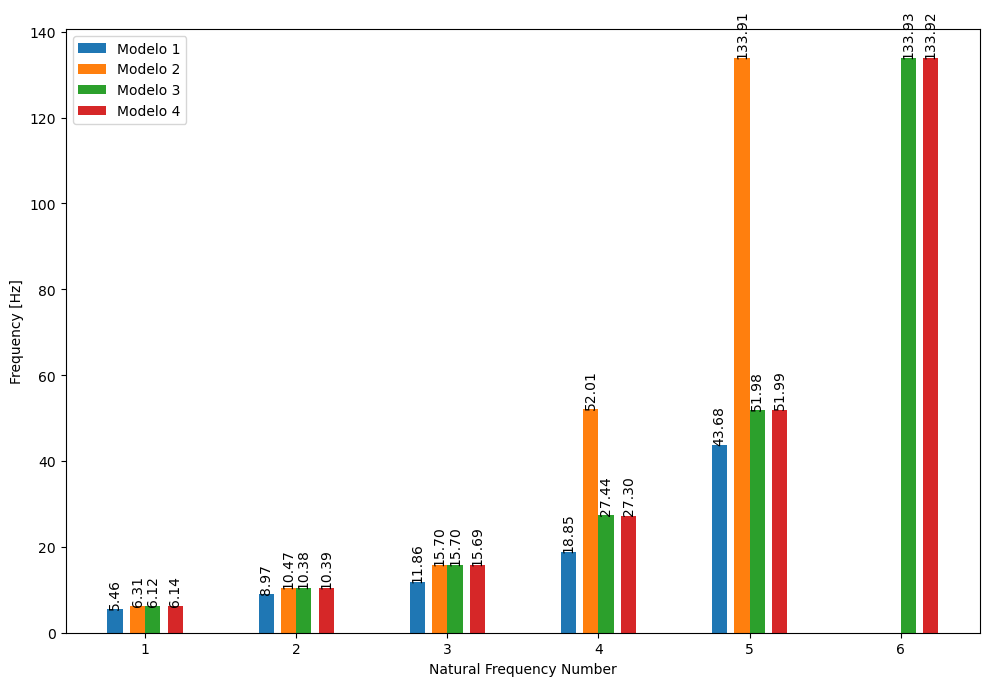

In [7]:

def bar_plot_values(bars,rotation):
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height,
                 f'{height:.2f}', ha='center', va='bottom',rotation=rotation)


plt.figure(figsize=(10,7))

freq = np.arange(5) + 1
freq2 = np.arange(6) + 1

width = 0.10
bar1 = plt.bar(freq - width*2, models_f_Hz[1], width, label = 'Modelo 1')
bar2 = plt.bar(freq - width/2, models_f_Hz[2], width, label = 'Modelo 2')
bar3 = plt.bar(freq2 + width/2, models_f_Hz[3], width, label = 'Modelo 3')
bar4 = plt.bar(freq2 + width*2, models_f_Hz[4], width, label = 'Modelo 4')

bar_plot_values(bar1, rotation=90)
bar_plot_values(bar2, rotation=90)
bar_plot_values(bar3, rotation=90)
bar_plot_values(bar4, rotation=90)

plt.legend()

plt.xlabel("Natural Frequency Number")
plt.ylabel("Frequency [Hz]")
plt.tight_layout()
plt.show()
